# Continuous Control : train a double jointed arm to move to target positions

---

In this noteboook, we are solving the Udacity project 2 for the Deep Reinforcement Learning nanodegree. The project consists on training a double jointed arm to move to target locations. The goal of the trained agent is to maintain its position at the target location for as many time as possible

The environment we are using is the [Unity ML-Agents environment](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) 

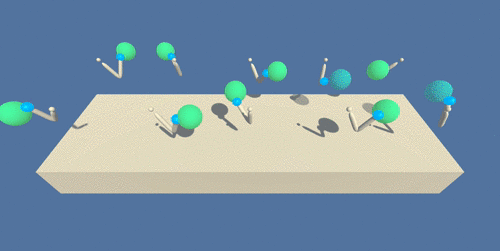


In [1]:
#the following command line install the environment in the Udacity workspace
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.3 which is incompatible.


### 1. Start the Environment


In [2]:
# Loading the environment version with 1 agent (here the one from udacity workspace)
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


When finished, you can close the environment.

In [ ]:
env.close()

### 4.Train the agent using DDPQ (Deep Deterministic Policy Gradients)

In [2]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from unityagents import UnityEnvironment
from agent import Agent
from workspace_utils import active_session

In [3]:
# We are selecting the version of the environment with 1 agent
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# get size of states in the environment
states = env_info.vector_observations
state_size = states.shape[1]
agents_nb = len(env_info.agents)

# get amount of possible actions in the environment
action_size = brain.vector_action_space_size

In [5]:
def ddpg_single(n_episodes=10000, max_t=1000, print_every=10):
    '''
    function to train using DDPG algorithm
    INPUTS:
        n_episodes. int, max number of episodes, default value = 10000
        max_t; int, max number of trajectories, default value = 1000
        print_every; int, score printing frequency, default = 10
    OUTPUTS:
        scores; list, contain the history of all scores collected during training
    '''
    
    #init the agent
    agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)
    
    scores_deque = deque(maxlen=100)
    scores = []
    
    
    for i_episode in range(1, n_episodes+1):
        
        #reset the environment and prepare for training
        env_info = env.reset(train_mode=True)[brain_name]
        
        #reset the agent
        agent.reset()
        
        # get the state of the environment
        state = env_info.vector_observations[0]
                
        #set the initial score of the agent to 0
        score = 0
               
        
        for t in range(max_t):
            
            #get action
            action = agent.act(state,add_noise=True)
        
            #send the selected action to the environment and collect next_state; reward; done or not
            env_info = env.step(action)[brain_name]        # send the actions to the environment
            next_state = env_info.vector_observations[0]   # get the next state for each agent
            reward = env_info.rewards[0]                  # get the reward for each agent
            done = env_info.local_done[0]                 # see if episode has finished
            
            #agent step
            agent.step(state, action, reward, next_state, done)
            
            
            #add score
            score += reward
            
            #set state to next state
            state = next_state
         
            #break if the agent is done
            if done:
                break 
                
        #store scores
        scores.append(score)
        scores_deque.append(score)

        #save intermediary checkpoints
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
        #environment is solved is average score over last 100 episodes is above 30
        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            
            break 
    return scores


Episode 10	Average Score: 0.53
Episode 20	Average Score: 0.82
Episode 30	Average Score: 0.93
Episode 40	Average Score: 1.34
Episode 50	Average Score: 1.68
Episode 60	Average Score: 2.22
Episode 70	Average Score: 2.51
Episode 80	Average Score: 2.74
Episode 90	Average Score: 3.03
Episode 100	Average Score: 3.36
Episode 110	Average Score: 3.97
Episode 120	Average Score: 4.65
Episode 130	Average Score: 5.50
Episode 140	Average Score: 6.35
Episode 150	Average Score: 7.40
Episode 160	Average Score: 8.05
Episode 170	Average Score: 9.39
Episode 180	Average Score: 10.45
Episode 190	Average Score: 12.08
Episode 200	Average Score: 13.81
Episode 210	Average Score: 15.38
Episode 220	Average Score: 16.75
Episode 230	Average Score: 18.05
Episode 240	Average Score: 19.53
Episode 250	Average Score: 21.08
Episode 260	Average Score: 22.90
Episode 270	Average Score: 24.23
Episode 280	Average Score: 25.26
Episode 290	Average Score: 25.83
Episode 300	Average Score: 26.36
Episode 310	Average Score: 27.20
Epi

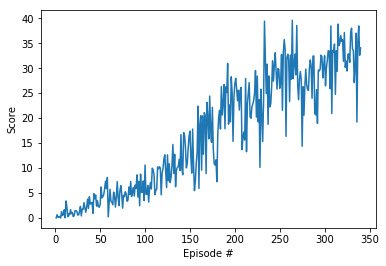

In [6]:
#use with active_session option to avoid having udacity session going to idle
with active_session():
    scores = ddpg_single()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
env.close()